In [20]:
import os

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr

from sdm_eurec4a.visulization import set_custom_rcParams
from sdm_eurec4a.visulization import symlog_from_array
from sdm_eurec4a.identifications import match_clouds_and_dropsondes, match_clouds_and_cloudcomposite, select_individual_cloud

In [21]:
plt.style.use("default")
default_colors = set_custom_rcParams()

# THE PATH TO THE SCRIPT DIRECTORY
script_dir = Path(os.path.abspath('/home/m/m301096/repositories/sdm-eurec4a/scripts/issues'))
print(script_dir)

REPOSITORY_ROOT = Path(script_dir).parents[1]
print(REPOSITORY_ROOT)

fig_path = script_dir
fig_path.mkdir(parents=True, exist_ok=True)


/home/m/m301096/repositories/sdm-eurec4a/scripts/issues
/home/m/m301096/repositories/sdm-eurec4a


### Load datasets

In [22]:
# Load data
# mask_name = "cloud_mask"
# chosen_id = 1421
mask_name = "rain_mask"
chosen_id = 77

identified_clouds = xr.open_dataset(
    REPOSITORY_ROOT
    / Path(
        f"data/observation/cloud_composite/processed/identified_clouds/identified_clouds_{mask_name}.nc"
    )
)
# select only clouds which are between 800 and 1100 m
identified_clouds = identified_clouds.where(
    (identified_clouds.alt >= 800) & (identified_clouds.alt <= 1100), drop=True
)

distance_IC_DS = xr.open_dataset(
    REPOSITORY_ROOT / Path(f"data/observation/combined/distance/distance_dropsondes_clouds_{mask_name}.nc")
)

cloud_composite = xr.open_dataset(
    REPOSITORY_ROOT / Path("data/observation/cloud_composite/processed/cloud_composite.nc"),
    chunks={"time": 1000},
)

drop_sondes = xr.open_dataset(
    REPOSITORY_ROOT
    / Path("data/observation/dropsonde/Level_3/EUREC4A_JOANNE_Dropsonde-RD41_Level_3_v2.0.0.nc")
)
drop_sondes = drop_sondes.rename({"launch_time": "time"})
drop_sondes = drop_sondes.swap_dims({"sonde_id": "time"})
drop_sondes = drop_sondes.sortby("time")
drop_sondes = drop_sondes.chunk({"time": -1})

Chose an individual cloud to handle.
Use ``chosen_id = 77`` for the rain_mask case
Use ``chosen_id = 1421`` for the cloud_mask case

In [23]:
# select a single cloud
ds_cloud = select_individual_cloud(identified_clouds, chosen_id)
ds_sonde = match_clouds_and_dropsondes(
    ds_cloud=ds_cloud,
    ds_sonde=drop_sondes,
    ds_distance=distance_IC_DS,
    max_temporal_distance=np.timedelta64(1, "h"),
    max_spatial_distance=100,
)

ds_cloudcomposite = match_clouds_and_cloudcomposite(
    ds_cloud=ds_cloud,
    ds_cloudcomposite=cloud_composite,
)

#### Plot the distributions in linear and lognormal space

Compare Particle Size Distribution **WITH and WITHOUT normalized** by bin width

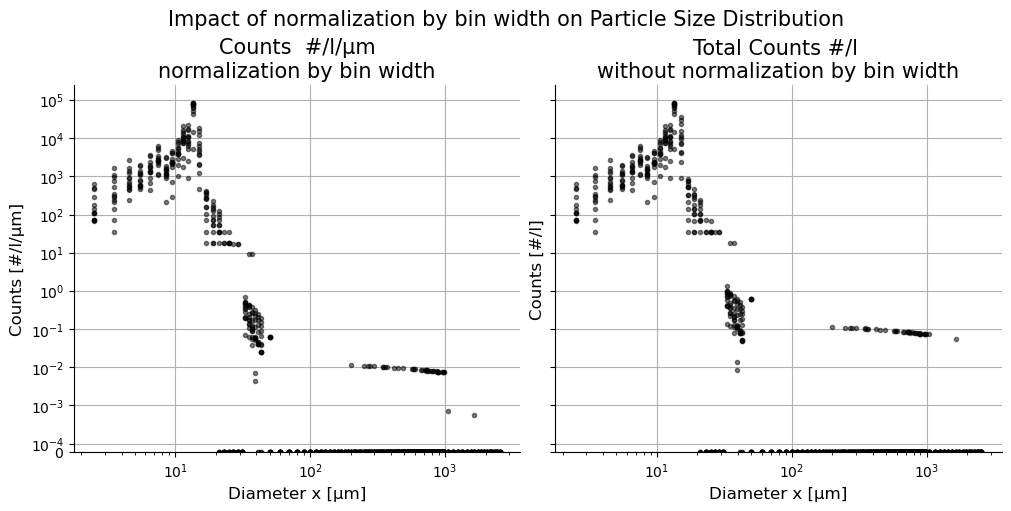

In [24]:
style = dict(
    marker = ".",
    linestyle = "none",
    color = "k",
    alpha = 0.5,
)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex = True, sharey = True, layout = 'constrained')

fig.suptitle(f"Impact of normalization by bin width on Particle Size Distribution")

psd = ds_cloudcomposite["particle_size_distribution"]
symlog = symlog_from_array(psd, axes=axs[0])
axs[0].plot(
    psd["diameter"], 
    psd,
    **style,
)
axs[0].set_title("Counts  #/l/µm\nnormalization by bin width")
axs[0].set_xscale("log")
axs[0].set_yscale(symlog)
axs[0].set_xlabel("Diameter x [µm]")
axs[0].set_ylabel("Counts [#/l/µm]")

psd = ds_cloudcomposite["particle_size_distribution"] * ds_cloudcomposite["bin_width"]
symlog = symlog_from_array(psd, axes=axs[1])
axs[1].plot(
    psd["diameter"], 
    psd,
    **style,
)
axs[1].set_title("Total Counts #/l \nwithout normalization by bin width")
axs[1].set_xscale("log")
axs[1].set_yscale(symlog)
axs[1].set_xlabel("Diameter x [µm]")
axs[1].set_ylabel("Counts [#/l]")

for ax in axs.flatten() :
    ax.set_ylim(0,None)
    ax.grid(True)

fig.savefig(fig_path / f"28_psd_normalization_cloud_{chosen_id}_{mask_name}.png", dpi=300, bbox_inches="tight")